# Decision Tree Approach

## Setup

In [633]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.calibration import calibration_curve

pd.set_option('display.max_rows', 500)

k2_df = pd.read_csv('data/K2_2024.06.06_20.23.11.csv', comment='#')
kep_df = pd.read_csv('data/KOI_2024.06.06_20.22.41.csv', comment='#')

In [634]:
print(k2_df.shape)
print(k2_df['disposition'].value_counts())

(3839, 16)
disposition
CONFIRMED         2156
CANDIDATE         1372
FALSE POSITIVE     293
REFUTED             18
Name: count, dtype: int64


In [635]:
k2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pl_name      3839 non-null   object 
 1   hostname     3839 non-null   object 
 2   disposition  3839 non-null   object 
 3   pl_orbper    3800 non-null   float64
 4   pl_orbsmax   777 non-null    float64
 5   pl_rade      3030 non-null   float64
 6   pl_insol     519 non-null    float64
 7   pl_eqt       709 non-null    float64
 8   pl_trandur   2718 non-null   float64
 9   st_teff      2731 non-null   float64
 10  st_rad       3715 non-null   float64
 11  st_mass      1968 non-null   float64
 12  st_met       1568 non-null   float64
 13  st_logg      2204 non-null   float64
 14  sy_dist      3716 non-null   float64
 15  sy_kepmag    3824 non-null   float64
dtypes: float64(13), object(3)
memory usage: 480.0+ KB


In [636]:
print(kep_df.shape)
print(kep_df['koi_disposition'].value_counts())

(9564, 16)
koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2743
CANDIDATE         1982
Name: count, dtype: int64


In [637]:
kep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   kepid            9564 non-null   int64  
 1   kepoi_name       9564 non-null   object 
 2   kepler_name      2745 non-null   object 
 3   koi_disposition  9564 non-null   object 
 4   koi_period       9564 non-null   float64
 5   koi_duration     9564 non-null   float64
 6   koi_prad         9201 non-null   float64
 7   koi_sma          9201 non-null   float64
 8   koi_teq          9201 non-null   float64
 9   koi_insol        9243 non-null   float64
 10  koi_steff        9201 non-null   float64
 11  koi_slogg        9201 non-null   float64
 12  koi_smet         9178 non-null   float64
 13  koi_srad         9201 non-null   float64
 14  koi_smass        9201 non-null   float64
 15  koi_kepmag       9563 non-null   float64
dtypes: float64(12), int64(1), object(3)
memory usage: 1.2+ MB


## Data Prep
### Data Augmentation

In [638]:
column_mapping = {
    'status': ['disposition', 'koi_disposition'], # target, status of the object
    'orbital_period': ['pl_orbper', 'koi_period'], # orbital period
    'semi_major_axis': ['pl_orbsmax', 'koi_sma'], # semi-major axis
    'planet_radius': ['pl_rade', 'koi_prad'], # planet radius
    'transit_duration': ['pl_trandur', 'koi_duration'], # transit duration
    'insolation_flux': ['pl_insol', 'koi_insol'], # insolation flux
    'equilibrium_temperature': ['pl_eqt', 'koi_teq'], # equilibrium temperature
    'kepler_magnitude': ['sy_kepmag', 'koi_kepmag'], # Kepler magnitude
    'stellar_radius': ['st_rad', 'koi_srad'], # stellar radius
    'stellar_effective_temperature': ['st_teff', 'koi_steff'], # stellar effective temperature
    'stellar_surface_gravity': ['st_logg', 'koi_slogg'], # stellar surface gravity
    'stellar_mass': ['st_mass', 'koi_smass'], # stellar mass
    'stellar_metallicity': ['st_met', 'koi_smet'] # stellar metallicity
}

In [639]:
# Create mappings for K2 and Kepler datasets
k2_column_mapping = {v[0]: k for k, v in column_mapping.items()}
kep_column_mapping = {v[1]: k for k, v in column_mapping.items()}

k2_df_selected = k2_df[k2_column_mapping.keys()].rename(columns=k2_column_mapping)

kep_df_selected = kep_df[kep_column_mapping.keys()].rename(columns=kep_column_mapping)

combined_df = pd.concat([k2_df_selected, kep_df_selected], axis=0, ignore_index=True)

print(combined_df.shape)

(13403, 13)


In [640]:
disposition_counts = combined_df['status'].value_counts()
print(disposition_counts)

status
FALSE POSITIVE    5132
CONFIRMED         4899
CANDIDATE         3354
REFUTED             18
Name: count, dtype: int64


In [641]:
df = combined_df[combined_df['status'] != 'CANDIDATE']
df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})

disposition_counts = df['status'].value_counts()
print(disposition_counts)

status
0    5150
1    4899
Name: count, dtype: int64


C:\Users\kflin\AppData\Local\Temp\ipykernel_16760\244264496.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})
C:\Users\kflin\AppData\Local\Temp\ipykernel_16760\244264496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].replace({'FALSE POSITIVE': 0, 'REFUTED': 0, 'CONFIRMED': 1})


### Features Selection

In [642]:
features = list(new_column_names.values())
features.remove('status')
print(features)

['orbital_period', 'semi_major_axis', 'planet_radius', 'transit_duration', 'insolation_flux', 'equilibrium_temperature', 'kepler_magnitude', 'stellar_radius', 'stellar_effective_temperature', 'stellar_surface_gravity', 'stellar_mass', 'stellar_metallicity']


### Remove Nulls

In [643]:
# count null values
null_counts = df.isnull().sum()
print(null_counts)

status                              0
orbital_period                     19
semi_major_axis                  1981
planet_radius                     800
transit_duration                  916
insolation_flux                  2219
equilibrium_temperature          2100
kepler_magnitude                    8
stellar_radius                    353
stellar_effective_temperature     784
stellar_surface_gravity          1131
stellar_mass                     1128
stellar_metallicity              1517
dtype: int64


In [644]:
# drop rows with null values
df = df.dropna()

disposition_counts = df['status'].value_counts()
print(disposition_counts)

status
0    4561
1    2825
Name: count, dtype: int64


### Define Features and Target

In [645]:
X = df.drop(columns=['status'])
y = df['status']

### Normalize Features and Fix Class Imbalance
The class imbalance did not end up being great enough that fixing the imbalance improved model performance.

In [646]:
scalar = StandardScaler()
X[features] = scalar.fit_transform(X[features]) 

#rus = RandomUnderSampler(random_state=0)
#X, y = rus.fit_resample(X, y)

#ros = RandomOverSampler(random_state=0)
#X, y = ros.fit_resample(X, y)

#print("X:", X.shape)
#print("y:", y.shape)

### Train / Test / Validation Splits

In [647]:
# 70/15/15 train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print("X:", X.shape, "X_train shape:", X_train.shape, "X_test shape:", X_test.shape, "X_val shape:", X_val.shape)

X: (7386, 12) X_train shape: (5170, 12) X_test shape: (1108, 12) X_val shape: (1108, 12)


## Models
### Hyperparameter Tuning

In [648]:
# Commenting out to avoid running grid search again

#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

#rf_model = RandomForestClassifier(random_state=0)
#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
#grid_search.fit(X_train, y_train)

#best_rf_model = grid_search.best_estimator_
#print("Best parameters for RF Model:", grid_search.best_params_)

In [649]:
# Commenting out to avoid running grid search again

#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#}

#gb_model = GradientBoostingClassifier(random_state=0)
#grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
#grid_search.fit(X_train, y_train)

#best_gb_model = grid_search.best_estimator_
#print("Best parameters for GB Model:", grid_search.best_params_)

### Bootstrap Aggregation

In [650]:
rf_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=1, min_samples_split=2, max_depth= None, random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

### Gradient Boosting

In [651]:
gb_model = GradientBoostingClassifier(n_estimators=300, max_depth= 10, random_state=0)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=300, random_state=0)

## Evaluation

In [652]:
rf_y_pred_prob = rf_model.predict_proba(X_val)
rf_y_pred = rf_model.predict(X_val)

rf_log_loss = log_loss(y_val, rf_y_pred_prob)
rf_accuracy = accuracy_score(y_val, rf_y_pred)
rf_confusion_matrix = confusion_matrix(y_val, rf_y_pred)

In [653]:
gb_y_pred_prob = gb_model.predict_proba(X_val)
gb_y_pred = gb_model.predict(X_val)

gb_log_loss = log_loss(y_val, gb_y_pred_prob)
rf_accuracy = accuracy_score(y_val, gb_y_pred)
gb_confusion_matrix = confusion_matrix(y_val, gb_y_pred)

In [654]:
print("Random Forest Log Loss:", rf_log_loss)
print("Random Forest Accuracy:", rf_accuracy)

print("Gradient Boosting Log Loss:", gb_log_loss)
print("Gradient Boosting Accuracy:", rf_accuracy)

Random Forest Log Loss: 0.2830521677272963
Random Forest Accuracy: 0.9115523465703971
Gradient Boosting Log Loss: 0.4187717031042331
Gradient Boosting Accuracy: 0.9115523465703971


In [655]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(4, 3))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)

    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
        
    plt.tight_layout()
    plt.show()

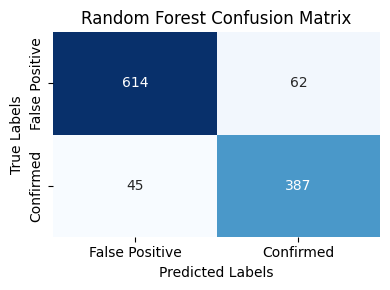

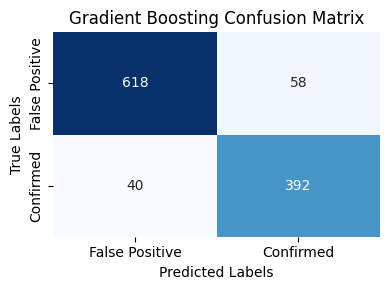

In [656]:
plot_confusion_matrix(rf_confusion_matrix, ['False Positive', 'Confirmed'], title='Random Forest Confusion Matrix')
plot_confusion_matrix(gb_confusion_matrix, ['False Positive', 'Confirmed'], title='Gradient Boosting Confusion Matrix')

### Cross-Validation

In [657]:
k = 5

kf = KFold(n_splits=k, random_state=0, shuffle=True)

rf_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')

print("Random Forest Cross Validation Accuracy Mean:", rf_scores.mean())

gb_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='accuracy')

print("Gradient Boosting Cross Validation Accuracy Mean:", gb_scores.mean())

Random Forest Cross Validation Accuracy Mean: 0.9044135471913499
Gradient Boosting Cross Validation Accuracy Mean: 0.9110482518142415


In [658]:
def plot_calibration_curve(y_true, y_prob, title='Calibration Curve'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_prob, y_true, 's-', label='Calibration curve')
    plt.plot([0, 1], [0, 1], color='gray', label='Ideal calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

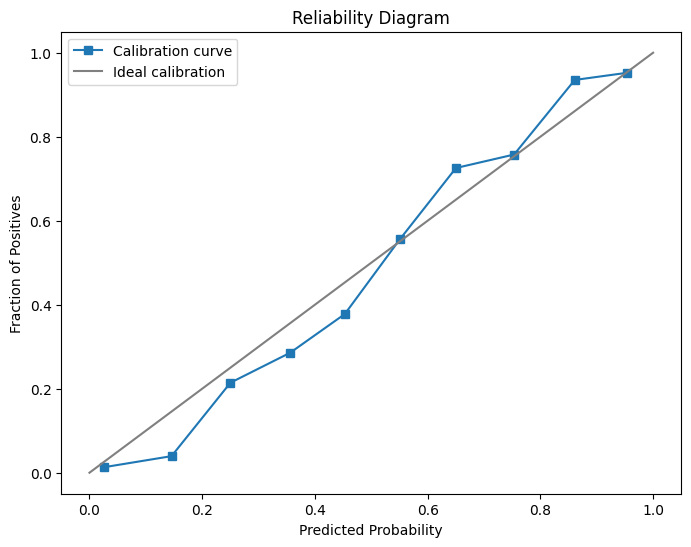

In [659]:
prob_true, prob_pred = calibration_curve(y_val, rf_y_pred_prob[:, 1], n_bins=10)

plot_calibration_curve(prob_true, prob_pred, title='Random Forest Calibration Curve')

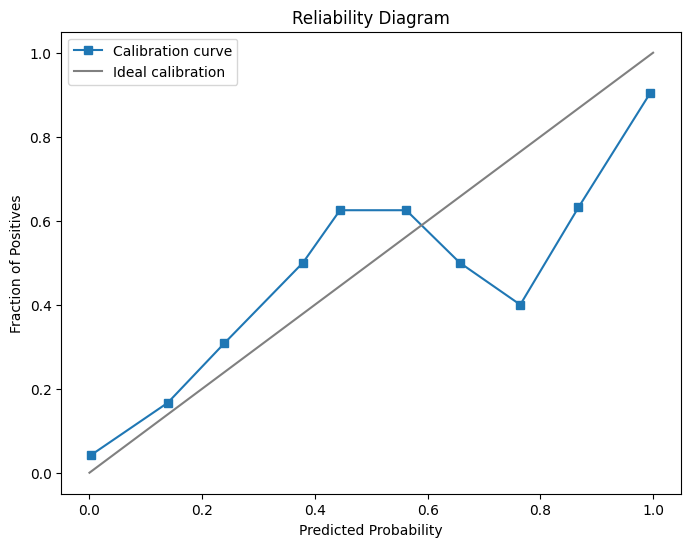

In [660]:
prob_true, prob_pred = calibration_curve(y_val, gb_y_pred_prob[:, 1], n_bins=10)

plot_calibration_curve(prob_true, prob_pred, title='Gradient Boosting Calibration Curve')